In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python.retinotopy import utils as retutils
from pipeline.python.retinotopy import segment_retinotopy as seg

from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

from pipeline.python.classifications import decode_utils as dutils
from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils

%matplotlib notebook

In [21]:
responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05
experiment='blobs'

traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [22]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette(soft=True)
dpi = putils.set_plot_params()

#### Responsive params
n_stds = None if responsive_test=='ROC' else 2.5 #None
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 


In [23]:
# Get all data sets
visual_areas = ['V1', 'Lm', 'Li']
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata['visual_area'].unique()

Segmentation: missing 9 dsets


array([u'Li', u'Ll', u'Lm', u'V1'], dtype=object)

In [558]:
print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")

curr_visual_area=None #'V1'
curr_datakey = None# '20190617_JC097_fov1'

#### Load neural responses
analysis_type='by_fov'
trial_epoch='plushalf'
response_type='dff'

stack_neuraldf = False

#### Check for equal trial counts
sdata, all_cells, MEANS, SDF = aggr.get_source_data(experiment,
                        equalize_now=False, zscore_now=False,
                        response_type=response_type, responsive_test=responsive_test,
                        responsive_thr=responsive_thr, trial_epoch=trial_epoch,
                        visual_area=curr_visual_area, datakey=curr_datakey,
                        check_configs=True, return_configs=True, return_missing=False,
                        images_only=False)

all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
all_cells.groupby(['visual_area']).count()

............................................
Responsive test: ROC (thr=0.05)
............................................
Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
(skipping 20190314_JC070_fov1)
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])


,cell,fov,animalid,session,datakey,fovnum,global_ix
visual_area,,,,,,,
Li,585,585,585,585,585,585,585
Lm,1127,1127,1127,1127,1127,1127,1127
V1,1251,1251,1251,1251,1251,1251,1251


In [559]:
overlap_thr=None
has_retino=False
threshold_dff=False
threshold_snr=False
match_distns = False
remove_too_few=False
min_ncells=5

stack_neuraldf = True
NDATA, CELLS = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                stack_neuraldf=True, overlap_thr=overlap_thr, has_retino=has_retino, 
                threshold_snr=threshold_snr, remove_too_few=remove_too_few, min_ncells=min_ncells,
                threshold_dff=threshold_dff) 
                                
print("------------------------------------")
print("Final cell counts:")
CELLS[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

cell_counts = dict(CELLS.groupby(['visual_area'])['cell'].count())

print("@@@@@@@@ cell counts @@@@@@@@@@@")
print(cell_counts)

print("Max/min (%s): %.2f, %.2f" % (response_type, NDATA['response'].max(), NDATA['response'].min()))

~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1127, u'Li': 585}
------------------------------------
------------------------------------
Final cell counts:
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1127, u'Li': 585}
Max/min (dff): 4.97, -0.56


In [560]:
ndf.head()

,config,trial,cell,response
0,config001,833.147059,4,0.019672
1,config002,840.151515,4,0.019739
2,config003,839.823529,4,0.019976
3,config004,841.545455,4,0.019739
4,config005,837.058824,4,0.020089


# Stdev?

In [179]:
x0 = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
m = x0.groupby(['cell', 'config']).mean().reset_index()


n2 = aggr.stacked_neuraldf_to_unstacked(m)
n2.shape
n3 = n2.drop('config', axis=1).divide(n2.drop('config', axis=1).sum(axis=0), axis=1)
n3['config'] = n2['config'].values
ndf = aggr.unstacked_neuraldf_to_stacked(n3)

sz_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
            for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['size'])], axis=1)

mp_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
            for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['morphlevel'])], axis=1)


<IPython.core.display.Javascript object>


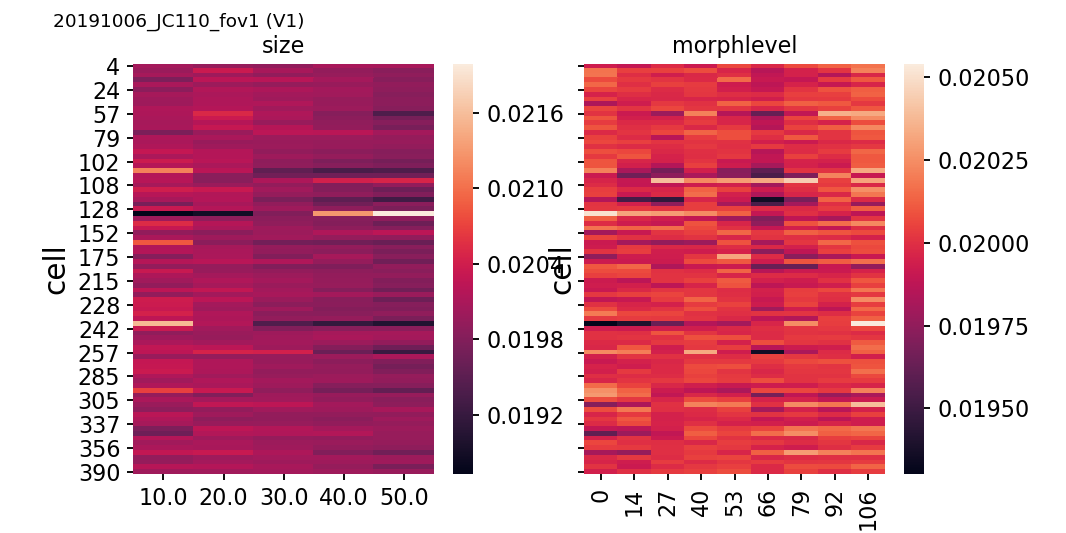

Text(0.05,0.95,u'20191006_JC110_fov1 (V1)')

In [188]:
fig, axn = pl.subplots(1,2, figsize=(8,4), sharey=True)
sns.heatmap(sz_df, ax=axn[0])
axn[0].set_title('size')

sns.heatmap(mp_df, ax=axn[1])
axn[1].set_title('morphlevel')

fig.text(0.05, 0.95, '%s (%s)' % (datakey, visual_area))

In [172]:
sz_df.sum(axis=1)

cell
4      0.002988
5      0.002991
6      0.002981
11     0.002989
12     0.002983
24     0.002988
33     0.002988
38     0.002985
46     0.002989
55     0.002990
57     0.002985
61     0.002989
65     0.002984
76     0.002992
77     0.002992
79     0.002989
85     0.002984
86     0.002986
100    0.002988
101    0.002987
102    0.002983
103    0.002979
104    0.002974
106    0.002956
107    0.003017
108    0.002976
112    0.002992
116    0.002985
118    0.002950
121    0.002963
         ...   
243    0.002986
248    0.002990
252    0.002988
255    0.002984
257    0.002984
267    0.002985
275    0.002988
276    0.002988
279    0.002989
285    0.002987
298    0.002990
301    0.002982
302    0.002991
304    0.002975
305    0.002984
307    0.002998
310    0.002983
325    0.002985
336    0.002980
337    0.002981
338    0.002992
353    0.002987
354    0.002985
355    0.002986
356    0.002986
364    0.002991
375    0.002986
380    0.002986
383    0.002989
390    0.002988
Length: 86, dtype: 

In [139]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [189]:
t_=[]
for (visual_area, datakey), x0 in NDATA.groupby(['visual_area', 'datakey']):

    sdf = SDF[datakey].copy()
    #ndf = x0.copy()    
    m = x0.groupby(['cell', 'config']).mean().reset_index()
    n2 = aggr.stacked_neuraldf_to_unstacked(m)
    n3 = n2.drop('config', axis=1).divide(n2.drop('config', axis=1).sum(axis=0), axis=1)
    n3['config'] = n2['config'].values
    ndf = aggr.unstacked_neuraldf_to_stacked(n3)

#     rois_ = [r for r in x1.columns if putils.isnumber(r)]
#     x2 = x1[rois_].subtract(x1[rois_].min(axis=0))
#     x2['config'] = x1['config']
#     x2['trial'] = x2.index.tolist()
#     ndf = pd.melt(x2, id_vars=['config', 'trial'], var_name='cell', value_name='response')

    sz_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
                for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['size'])], axis=1)

    mp_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
                for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['morphlevel'])], axis=1)

    sz1 = sz_df.copy() #sz_df.divide(sz_df.sum(axis=1), axis=0)
    mp1 = mp_df.copy() #mp_df.divide(mp_df.sum(axis=1), axis=0)

    stds_sz = pd.DataFrame(sz1.std(axis=1), columns=['std'])
    stds_sz['condition'] = 'size'

    stds_mp = pd.DataFrame(mp1.std(axis=1), columns=['std'])
    stds_mp['condition'] = 'morphlevel'

    tmpdf = pd.concat([stds_sz, stds_mp], axis=0)
    tmpdf['cell'] = tmpdf.index.tolist()
    tmpdf['visual_area'] = visual_area
    tmpdf['datakey']=datakey
    
    t_.append(tmpdf)

In [205]:
sz_df

,10.0,20.0,30.0,40.0,50.0
cell,,,,,
4,0.020057,0.019939,0.019919,0.020085,0.020087
5,0.019981,0.020355,0.020077,0.019924,0.019859
6,0.020067,0.020012,0.019918,0.019955,0.019908
11,0.019765,0.020240,0.020206,0.020058,0.019844
12,0.020094,0.019999,0.019944,0.019963,0.019923
24,0.019882,0.020163,0.020125,0.020044,0.019892
33,0.020065,0.020108,0.020050,0.020029,0.019836
38,0.020017,0.020133,0.020014,0.019954,0.019874
46,0.020003,0.020139,0.020146,0.019968,0.019881


In [190]:
df = pd.concat(t_, axis=0)
df.head()

,std,condition,cell,visual_area,datakey
cell,,,,,
174,0.000041,size,174,Li,20190314_JC070_fov1
175,0.000028,size,175,Li,20190314_JC070_fov1
177,0.000059,size,177,Li,20190314_JC070_fov1
219,0.000023,size,219,Li,20190314_JC070_fov1
220,0.000017,size,220,Li,20190314_JC070_fov1


## plot fits

<IPython.core.display.Javascript object>


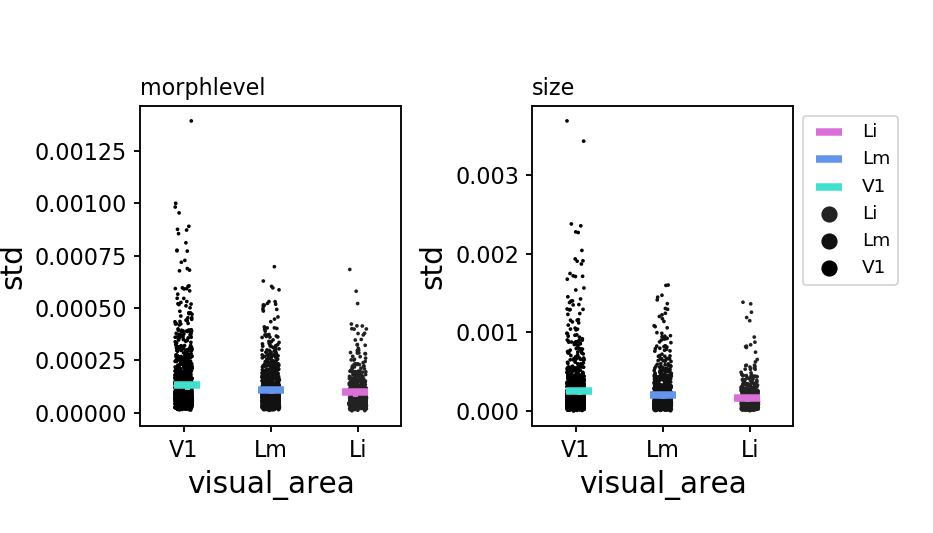

In [191]:

fig, axn = pl.subplots(1,2, figsize=(7,4))
    
for ai, (ax, (cond, mg)) in enumerate(zip(axn.flat, df.groupby(['condition']))):
    
    sns.pointplot(x='visual_area', y='std', data=mg, ax=ax, 
             hue='visual_area', palette=area_colors, order=visual_areas, scale=2,
                  markers='_', dodge=True, join=False)
    
    sns.stripplot(x='visual_area', y='std', data=mg, ax=ax, 
             hue='visual_area', color='k', order=visual_areas, size=2, zorder=-1)

    if ai==0:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(1., 1), loc='upper left')
    ax.set_title(cond, loc='left')

pl.subplots_adjust(left=0.15, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

## means by fov

<IPython.core.display.Javascript object>


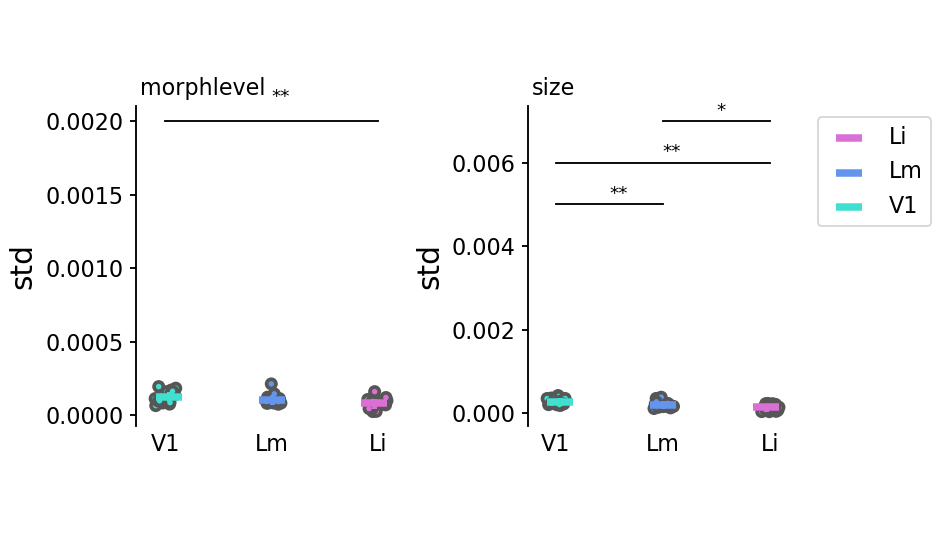

********* [std] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.060 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.009 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.091 (fdr_bh), reject H0=False
****************************
********* [std] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.005 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.013 (fdr_bh), reject H0=True
****************************


In [192]:
multi_comp_test='fdr_bh'

means_by_fov = df.groupby(['visual_area', 'datakey', 'condition' ]).mean().reset_index()

fig, axn = pl.subplots(1,2, figsize=(7,4))
for ai, (ax, (cond, mg)) in enumerate(zip(axn.flat, means_by_fov.groupby(['condition']))):
    
    sns.pointplot(x='visual_area', y='std', data=mg[mg.condition==cond], ax=ax, 
             hue='visual_area', palette=area_colors, order=visual_areas, scale=2,
                  markers='_', dodge=True, join=False)
    sns.stripplot(x='visual_area', y='std', data=mg[mg.condition==cond], ax=ax, 
             hue='visual_area', palette=area_colors, order=visual_areas, size=5, zorder=-1,
                 marker='o', linewidth=2) #, edgecolor=area_colors)
    
    yloc = 0.005 if cond=='size' else 0.001
    offset=0.001 if cond=='size' else 0.001
    statresults, ax = aggr.plot_mannwhitney(mg, metric='std', multi_comp_test=multi_comp_test,
                        ax=ax, y_loc=yloc, offset=offset)

    if ai==0:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(1., 1), loc='upper left')
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_title(cond, loc='left')

aggr.crop_legend_labels(axn[-1], n_hues=3)

sns.despine(offset=2, bottom=True)
pl.subplots_adjust(left=0.15, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

In [163]:
sz_df

,10.0,20.0,30.0,40.0,50.0
cell,,,,,
4,0.094116,0.018369,-0.008733,0.082674,0.149786
5,0.233096,0.682982,0.355833,0.305655,0.182584
6,-0.179547,-0.131600,-0.185578,-0.264171,-0.287733
11,-0.087088,0.497692,0.405343,0.232945,0.004884
12,-0.132480,-0.217202,-0.232267,-0.223750,-0.269533
24,-0.277637,0.007466,0.008658,-0.155453,-0.227467
33,-0.132329,-0.048930,-0.066121,-0.142573,-0.274953
38,-0.184715,-0.059707,-0.181414,-0.238363,-0.319117
46,-0.033121,0.086448,0.100412,-0.032527,-0.161588


# Selectivity & Tolerance

In [907]:
images_only=True

d_=[]
for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):
    sdf = SDF[dk].copy()
    rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
    rdf['size'] = [sdf['size'][c] for c in rdf['config']]
    rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]
    if images_only:
        rdf = rdf[rdf['morphlevel']!=-1]
    n_images = 45 if images_only else 50
    
    morph_ixs = rdf.groupby(['cell']).apply(assign_morph_ix, at_best_other=True).rename(columns={0:'morph_ix'})
    size_tols = rdf.groupby(['cell']).apply(assign_size_tolerance, at_best_other=True).rename(columns={0:'size_tol'})
    sparse_ixs = rdf[['cell', 'response']].groupby(['cell']).apply(assign_sparseness).rename(columns={0:'sparseness'})

    tmpdf = pd.concat([size_tols, morph_ixs, sparse_ixs], axis=1)
    tmpdf['visual_area'] = va
    tmpdf['datakey'] = dk
    d_.append(tmpdf)

ixdf = pd.concat(d_, axis=0).reset_index()
ixdf.head()

,cell,size_tol,morph_ix,sparseness,visual_area,datakey
0,174,0.950670,0.030409,0.000275,Li,20190314_JC070_fov1
1,175,0.948997,0.037606,0.000318,Li,20190314_JC070_fov1
2,177,0.933212,0.037092,0.000561,Li,20190314_JC070_fov1
3,219,0.973580,0.022953,0.000105,Li,20190314_JC070_fov1
4,220,0.975669,0.022626,0.000087,Li,20190314_JC070_fov1


In [908]:
min_ncells = 1
passdf = pd.concat([g for v, g in ixdf.groupby(['visual_area', 'datakey']) \
                    if len(g) > min_ncells])
mean_indices = passdf.groupby(['visual_area', 'datakey']).mean().reset_index()


In [909]:
c_=[]
for (va, dk), ixs_ in passdf.groupby(['visual_area', 'datakey']):
    pearsons_r, pearsons_p = spstats.pearsonr(ixs_['size_tol'], ixs_['morph_ix'])
    c = pd.Series({'pearsons_p': pearsons_p, 'pearsons_r': pearsons_r,
                   'visual_area': va, 'datakey': dk, 'n_cells': len(ixs_)})
    c_.append(c)

corrs = pd.concat(c_, axis=1).T

p_thr=0.05
corrs['pass'] = corrs['pearsons_p'] < p_thr

<IPython.core.display.Javascript object>


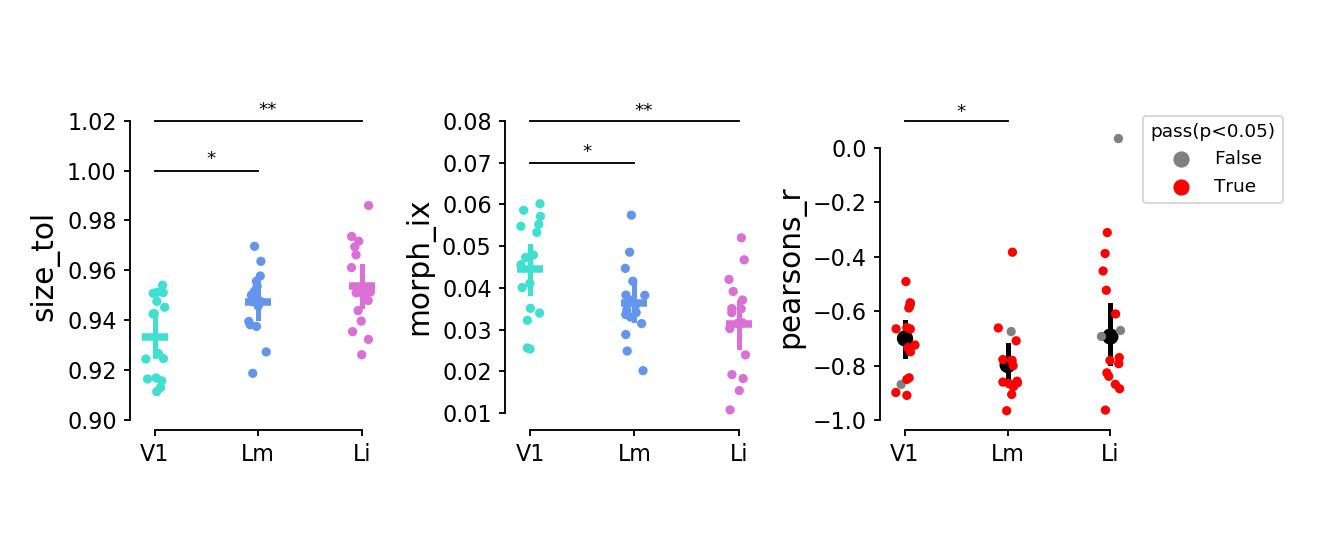

********* [size_tol] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.019 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.007 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.159 (fdr_bh), reject H0=False
****************************
********* [morph_ix] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.039 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.007 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.141 (fdr_bh), reject H0=False
****************************
********* [pearsons_r] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.047 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.427 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.160 (fdr_bh), reject H0=False
****************************


In [910]:
fig, axn = pl.subplots(1,3, figsize=(10,4))

ax=axn[0]
multi_comp_test='fdr_bh'

metric='size_tol'
for ai, metric in enumerate(['size_tol', 'morph_ix']):
    ax=axn[ai]
    sns.stripplot(x='visual_area', y=metric, data=mean_indices, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas)
    sns.pointplot(x='visual_area', y=metric, data=mean_indices, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas, join=False, 
                 markers='_', scale=2)
    ax.legend_.remove()
    y_loc=1 if metric=='size_tol' else 0.07
    offset=0.02 if metric=='size_tol' else 0.01
    statresults, ax = aggr.plot_mannwhitney(mean_indices, metric=metric, ax=ax, 
                                        multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)
#aggr.crop_legend_labels(axn[1], n_hues=3, bbox_to_anchor=(1, 1), loc='upper left')


ax=axn[2]
metric='pearsons_r'
sns.stripplot(x='visual_area', y='pearsons_r', data=corrs, ax=ax,
             hue='pass', palette={True: 'r', False: 'gray'}, dodge=False, order=visual_areas)
sns.pointplot(x='visual_area', y='pearsons_r', data=corrs[corrs['pass']], ax=ax,
             color='k', dodge=False, join=False, order=visual_areas)
y_loc=0.1
offset=0.1
statresults, ax = aggr.plot_mannwhitney(corrs[corrs['pass']], metric=metric, ax=ax, 
                                    multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)

sns.despine(offset=2, trim=True)
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.85, top=0.8, wspace=0.5)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', title='pass(p<%.2f)' % p_thr)

for ax in axn.flat:
    ax.set_xlabel('')
    
#putils.label_figure(fig, data_id)

<IPython.core.display.Javascript object>


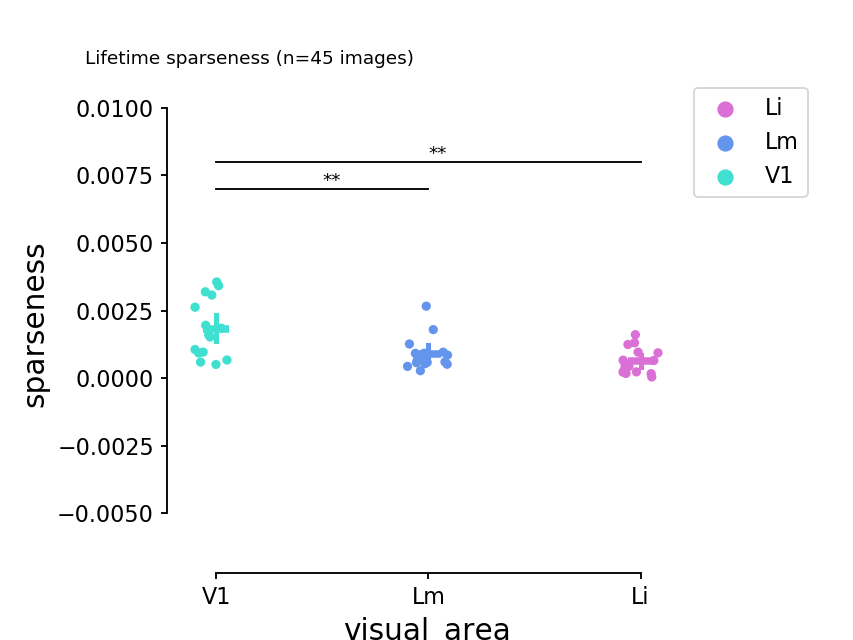

********* [sparseness] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.003 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.001 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.073 (fdr_bh), reject H0=False
****************************


Text(0.1,0.9,u'Lifetime sparseness (n=45 images)')

In [925]:
fig, ax = pl.subplots()
metric='sparseness'
sns.stripplot(x='visual_area', y=metric, data=mean_indices, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas)
sns.pointplot(x='visual_area', y=metric, data=mean_indices, ax=ax,
                 hue='visual_area', palette=area_colors, order=visual_areas, join=False, 
                 markers='_', scale=2)

y_loc=0.007
offset=0.001
statresults, ax = aggr.plot_mannwhitney(mean_indices, metric=metric, ax=ax, 
                                    multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)

sns.despine(offset=2, trim=True)
aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1,1), loc='upper left')
pl.subplots_adjust(left=0.2, right=0.8)

fig.text(0.1, 0.9, 'Lifetime sparseness (n=%i images)' % n_images)

In [912]:
ixs_[ixs_.cell.isin(rois_plot)]

,cell,size_tol,morph_ix,sparseness,visual_area,datakey
2887,57,0.844817,0.167629,0.002240,V1,20191006_JC110_fov1
2899,104,0.858944,0.047858,0.005312,V1,20191006_JC110_fov1
2901,107,0.905845,0.070213,0.001220,V1,20191006_JC110_fov1
2908,131,0.770452,0.066206,0.015298,V1,20191006_JC110_fov1
2914,167,0.802672,0.053844,0.005750,V1,20191006_JC110_fov1
2931,240,0.797823,0.100327,0.010095,V1,20191006_JC110_fov1
2937,257,0.887450,0.083092,0.003085,V1,20191006_JC110_fov1


# size

In [913]:
if NDATA['response'].min() < 0:
    NDATA['response'] = NDATA['response'] - NDATA['response'].min()
print(NDATA['response'].min())

0.0


In [914]:
visual_area = 'V1'
datakey = '20191006_JC110_fov1'

x0 = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
sdf = SDF[datakey].copy() #aggr.get_master_sdf()

x0.head()


,visual_area,datakey,config,trial,cell,response
0,V1,20191006_JC110_fov1,config012,1,4,0.579568
1,V1,20191006_JC110_fov1,config041,2,4,0.650755
2,V1,20191006_JC110_fov1,config024,3,4,0.607950
3,V1,20191006_JC110_fov1,config016,4,4,0.647592
4,V1,20191006_JC110_fov1,config049,5,4,0.606354


In [778]:
# x0 = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
m = x0.groupby(['cell', 'config']).mean().reset_index()

n2 = aggr.stacked_neuraldf_to_unstacked(m)
n2.shape
n3 = n2.drop('config', axis=1).divide(n2.drop('config', axis=1).sum(axis=0), axis=1)
n3['config'] = n2['config'].values
ndf = aggr.unstacked_neuraldf_to_stacked(n3)


In [779]:
test_configs = sdf[sdf['morphlevel']!=-1].index.tolist()
x=ndf.copy()
x['size'] = [sdf['size'][c] for c in ndf['config']]

std_sz = x[x.config.isin(test_configs)].groupby(['size', 'cell']).std().reset_index().drop('trial', axis=1)
piv_sz = std_sz.pivot(columns='size', index='cell')

x=ndf.copy()
x['morphlevel'] = [sdf['morphlevel'][c] for c in ndf['config']]

std_mp = x[x.config.isin(test_configs)].groupby(['morphlevel', 'cell']).std().reset_index().drop('trial', axis=1)
piv_mp = std_mp.pivot(columns='morphlevel', index='cell')



In [266]:
cell_ixs_sz, sz_ixs = np.where(piv_sz==piv_sz.max(axis=0))
#print(cell_ixs, sz_ixs)
print(piv_sz.iloc[cell_ixs_sz]*1000)

      response                                        
size      10.0      20.0      30.0      40.0      50.0
cell                                                  
57    0.686300  0.484187  0.690251  0.404962  0.227072
131   0.059209  0.124222  0.335106  0.448576  0.590107
167   0.517154  0.494219  0.307430  0.588709  0.568862
240   0.693259  0.484457  0.391094  0.428619  0.297965
257   0.293139  0.723026  0.462449  0.382076  0.244552


In [267]:
cell_ixs_mp, mp_ixs = np.where(piv_mp==piv_mp.max(axis=0))
print(piv_mp.iloc[cell_ixs_mp]*1000)

            response                                                    \
morphlevel       0         14        27        40        53        66    
cell                                                                     
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
131         1.802374  1.671866  1.785270  1.719807  1.428616  1.222675   
240         0.914875  0.743899  0.950807  1.012272  1.192339  1.042798   

                                          
morphlevel       79        92        106  
cell                     

<IPython.core.display.Javascript object>


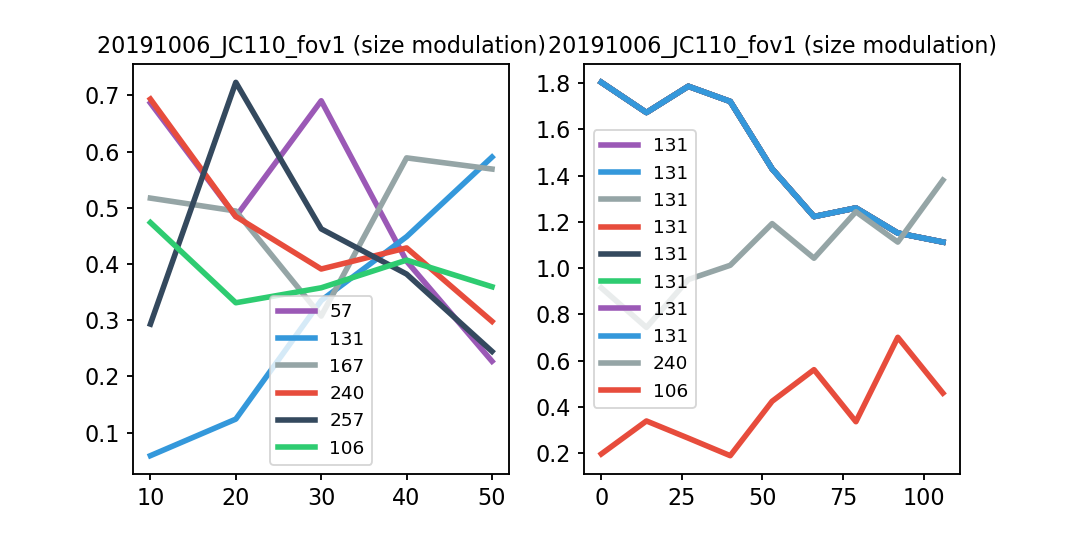

Text(0.5,1,u'20191006_JC110_fov1 (size modulation)')

In [270]:

lw=3
fig, axn= pl.subplots(1, 2, figsize=(8,4))
ax=axn[0]
for i in cell_ixs_sz:
    ax.plot(piv_sz.iloc[i]['response']*1000, label=piv_sz.iloc[i].name, lw=lw)
ax.plot(piv_sz.loc[106]['response']*1000, label=106, lw=lw)

ax.legend()
ax.set_title('%s (size modulation)' % datakey)


ax=axn[1]
for i in cell_ixs_mp:
    ax.plot(piv_mp.iloc[i]['response']*1000, label=piv_mp.iloc[i].name, lw=lw)
ax.plot(piv_mp.loc[106]['response']*1000, label=106, lw=lw)

ax.legend()
ax.set_title('%s (size modulation)' % datakey)

<IPython.core.display.Javascript object>


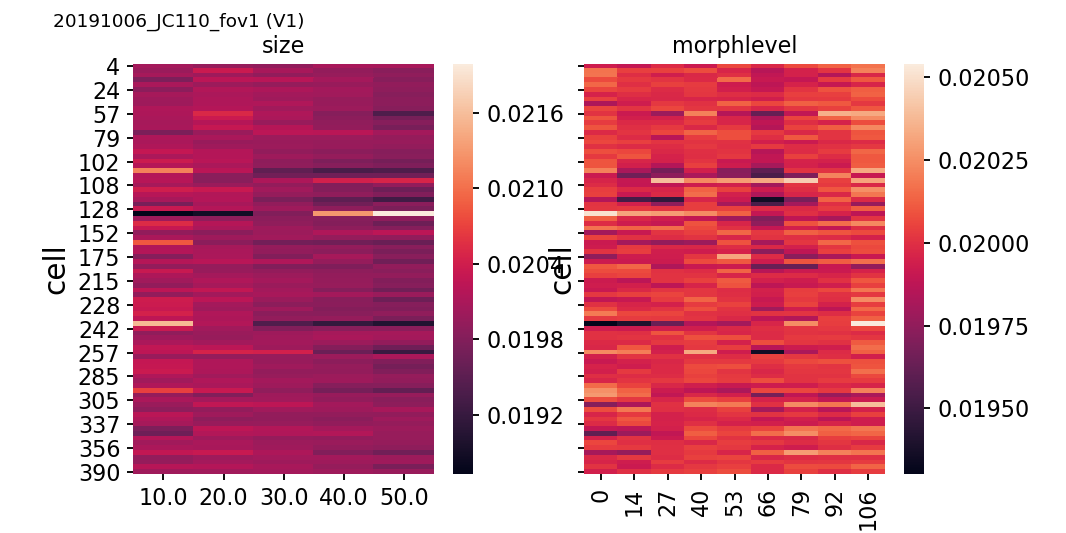

Text(0.05,0.95,u'20191006_JC110_fov1 (V1)')

In [275]:
sz_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
            for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['size'])], axis=1)

mp_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
            for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['morphlevel'])], axis=1)

fig, axn = pl.subplots(1,2, figsize=(8,4), sharey=True)
sns.heatmap(sz_df, ax=axn[0])
axn[0].set_title('size')

sns.heatmap(mp_df, ax=axn[1])
axn[1].set_title('morphlevel')

fig.text(0.05, 0.95, '%s (%s)' % (datakey, visual_area))

In [279]:
(5-(4./1))/(5-1)


0.25

# Morph selectivity

In [780]:
def get_x_curves_at_best_y(df, x='morphlevel', y='size', normalize=False):
    best_y = float(df[df['response']==df.groupby([x])['response'].max().max()][y])
    df_ = df[df[y]==best_y]
    #df_[y] = best_y
    
    if normalize:
        max_d = df_['response'].max()
        df_['response'] = df_['response']/max_d
    
    return df_
        
def assign_morph_ix(df, at_best_other=True):
    if at_best_other:
        df_ = get_x_curves_at_best_y(df, x='morphlevel', y='size', normalize=False)
    else:
        df_ = df.copy()
    mt = morph_tuning_index(df_['response'].values)
    
    return pd.Series(mt, name=df_['cell'].unique()[0])

def morph_tuning_index(responses):
    '''
    MT = [n - (sum(Ri)/Rmax)]/(n - 1)
    from: Zoccolan et al, 2007
    '''
    n = float(len(responses))
    Rmax = max(responses)
    mt = (n - (sum(responses)/Rmax)) / (n-1)
    
    return mt


def assign_size_tolerance(df, at_best_other=True):
    if at_best_other:
        df_ = get_x_curves_at_best_y(df, x='size', y='morphlevel', normalize=False)
    else:
        df_ = df.copy()
    mt = size_tolerance(df_['response'].values)
    
    return pd.Series(mt, name=df_['cell'].unique()[0])


def size_tolerance(responses):
    '''
    ST = mean( Rtest / max(Rtest) ), where mean is taken over all sizes
    from: Zoccolan et al, 2007
    '''
    normed_tuning = responses/float(max(responses))
    ST = np.mean(normed_tuning[normed_tuning<1.])
    
    return ST

def assign_sparseness(df):
    mt = sparseness(df['response'].values)
    return pd.Series(mt, name=df['cell'].unique()[0])


def sparseness(responses):
    '''
    num = 1 - [ (sum(Ri)/n)**2 / sum( ((Ri**2)/n) ) ] 
    denom = [1 - (1/n)]
    from:  Zoccolan et al, 2007; Rolls & Tovee, 1995; Vinje and Gallant, 2000; Olshausen and Field, 2004.
    '''
    n = float(len(responses))
    num = 1. - ( (sum(responses)/n)**2 / sum( (responses**2)/n ) )
    denom = (1. - (1./n))
    
    return (num/denom)

In [781]:
rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf['size'] = [sdf['size'][c] for c in rdf['config']]
rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]
rdf = rdf[rdf['morphlevel']!=-1]

In [782]:
#### Generate morph tuning curves
morph_curves = rdf.groupby(['cell']).apply(get_x_curves_at_best_y, 
                                           x='morphlevel', y='size', normalize=True).reset_index(drop=True)
morph_mat = morph_curves[['cell', 'response', 'morphlevel']].pivot(columns='cell', index='morphlevel')

print(morph_curves['size'].unique())


In [784]:
#### Calculate morph selectivity index
morph_ixs = rdf.groupby(['cell']).apply(assign_morph_ix, at_best_other=True).rename(columns={0:'morph_ix'})
sorted_morph_ixs = morph_ixs.sort_values(by='morph_ix', ascending=False)
print("Top 5:")
print(sorted_morph_ixs.iloc[0:5])
print("Bottom 5:")
print(sorted_morph_ixs.iloc[-5:])

Top 5:
      morph_ix
cell          
57    0.167629
240   0.100327
257   0.083092
133   0.072142
302   0.071970
Bottom 5:
      morph_ix
cell          
38    0.009972
285   0.009716
267   0.009322
153   0.008486
325   0.005947


In [785]:
#### Generate size tuning curves
size_curves = rdf.groupby(['cell']).apply(get_x_curves_at_best_y, 
                                           x='size', y='morphlevel', normalize=True).reset_index(drop=True)
size_mat = size_curves[['cell', 'response', 'size']].pivot(columns='cell', index='size')

In [787]:
#### Calculate size tolerance
size_tols = rdf.groupby(['cell']).apply(assign_size_tolerance, at_best_other=True).rename(columns={0:'size_tol'})
sorted_size_tols = size_tols.sort_values(by='size_tol', ascending=False)
print("Top 5:")
print(sorted_size_tols.iloc[0:5])
print("Bottom 5:")
print(sorted_size_tols.iloc[-5:])

Top 5:
      size_tol
cell          
355   0.988202
380   0.985668
390   0.982500
305   0.982484
4     0.982325
Bottom 5:
      size_tol
cell          
302   0.845798
57    0.844817
167   0.802672
240   0.797823
131   0.770452


In [ ]:
#### Calculate sparseness
sparse_ixs = rdf[['cell', 'response']].groupby(['cell']).apply(assign_sparseness).rename(columns={0:'sparseness'})

In [874]:
#### Aggregate
ixs_ = pd.concat([size_tols, morph_ixs, sparse_ixs], axis=1).reset_index()
ixs_.index=ixs_['cell']
ixs_.head()

,cell,size_tol,morph_ix,sparseness
cell,,,,
4,4,0.982325,0.040998,0.000290
5,5,0.963247,0.015003,0.000516
6,6,0.947806,0.042051,0.000307
11,11,0.942069,0.036501,0.000697
12,12,0.973949,0.022054,0.000167


<IPython.core.display.Javascript object>


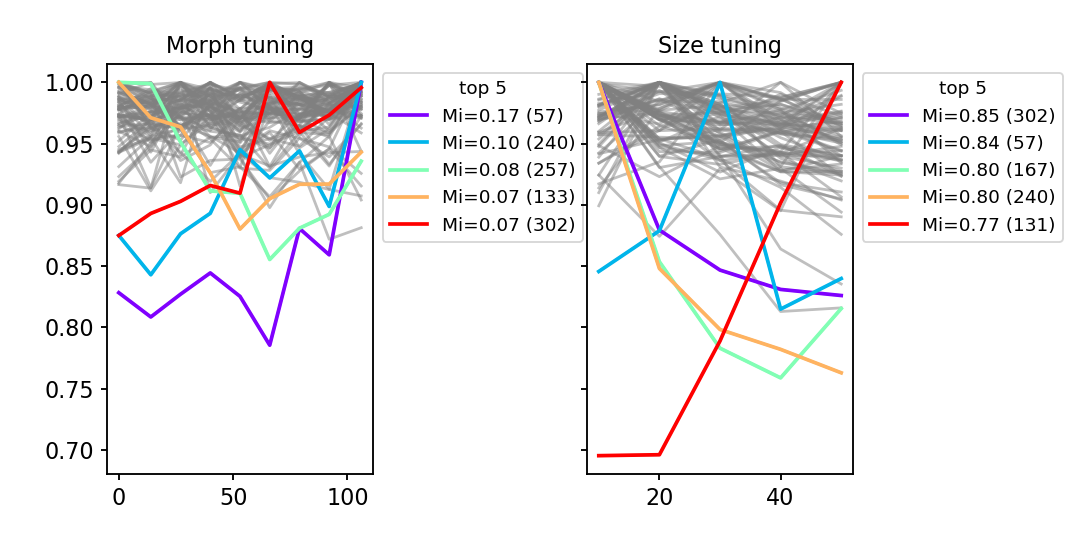

In [875]:
#### plot topntopn=5
roi_colors = pl.cm.rainbow(np.linspace(0, 1, topn))

fig, axn = pl.subplots(1,2, figsize=(8,4), sharey=True)

ax=axn[0]
ax.plot(morph_mat, color='gray', alpha=0.5)
ax.set_title("Morph tuning")
rois_plot_mp = sorted_morph_ixs.iloc[0:topn].index.tolist()
for col, rid in zip(roi_colors, rois_plot_mp):
    ax.plot(morph_mat['response', rid], color=col, lw=2, 
                label='Mi=%.2f (%i)' % (morph_ixs.loc[rid]['morph_ix'], rid))
ax.legend(title='top 5', bbox_to_anchor=(1, 1), loc='upper left')

ax=axn[1]
ax.plot(size_mat, color='gray', alpha=0.5)
ax.set_title("Size tuning")
rois_plot_sz = sorted_size_tols.iloc[-topn:].index.tolist()

for col, rid in zip(roi_colors, rois_plot_sz):
    ax.plot(size_mat['response', rid], color=col, lw=2, 
            label='Mi=%.2f (%i)' % (size_tols.loc[rid]['size_tol'], rid))
ax.legend(title='top 5', bbox_to_anchor=(1, 1), loc='upper left')

pl.subplots_adjust(wspace=0.8, left=0.1, right=0.8)

In [ ]:
#### Compare morph selectivity vs. size tolerance:

<IPython.core.display.Javascript object>


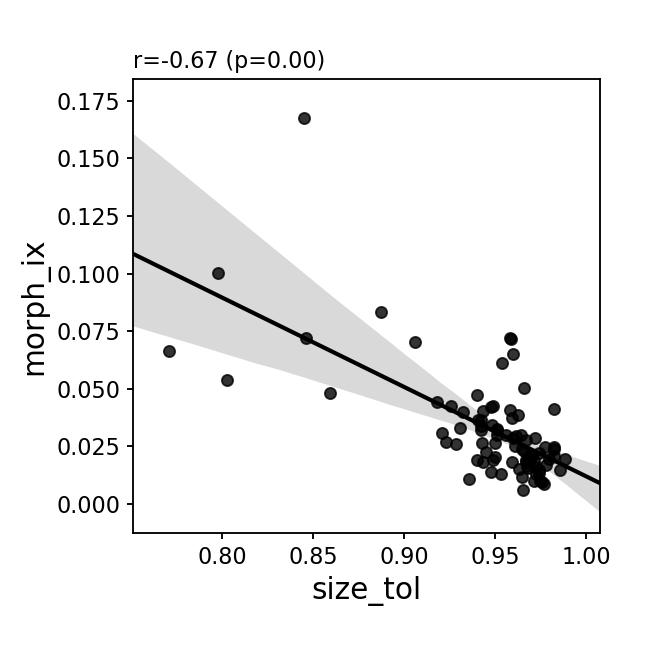

In [936]:
fig, ax = pl.subplots(figsize=(5,5))
sns.regplot(x='size_tol', y='morph_ix', data=ixs_, ax=ax, color='k')
pearsons_r, pearsons_p = spstats.pearsonr(ixs_['size_tol'], ixs_['morph_ix'])
ax.set_title("r=%.2f (p=%.2f)" % (pearsons_r, pearsons_p), loc='left')
pl.subplots_adjust(left=0.2, bottom=0.2)

In [696]:
print(rois_plot_mp)
print(rois_plot_sz)
rois_plot = np.union1d(rois_plot_mp, rois_plot_sz)


[57, 240, 257, 133, 302]
[302, 57, 167, 240, 131]


In [697]:
vmin = rdf[rdf.cell.isin(rois_plot)]['response'].min()
vmax = rdf[rdf.cell.isin(rois_plot)]['response'].max()
print(vmin, vmax)

(0.52002490646568, 0.7902469373691154)


<IPython.core.display.Javascript object>


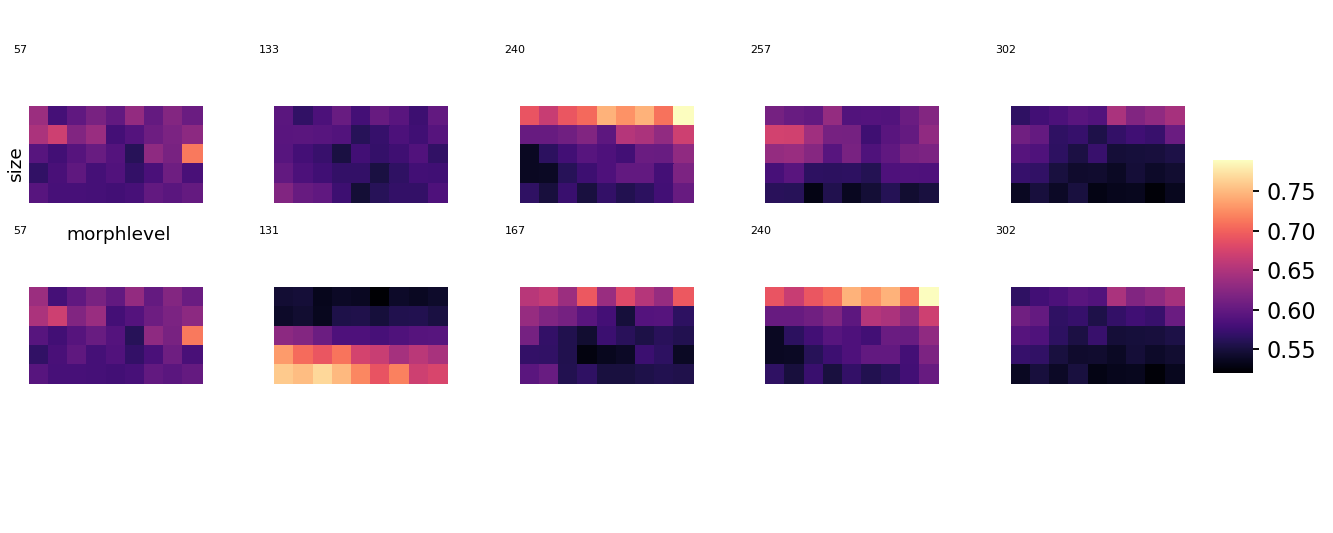

In [718]:
cmap='magma'
fig, axn = pl.subplots(2, topn, sharex=True, sharey=True, figsize=(10,4))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for ri, (roi, rd) in enumerate(rdf[rdf.cell.isin(rois_plot_mp)].groupby(['cell'])):
    ax=axn[0, ri]
    sns.heatmap(rd['response'].reshape(9,5).T, ax=ax,
                vmin=vmin, vmax=vmax, cmap=cmap, cbar=ri==0, cbar_ax=None if ri else cbar_ax)
    ax.set_aspect('equal')
    ax.set_title(roi, fontsize=6, loc='left')
    ax.axis('off')
fig.text(0.005, 0.7, 'size', rotation=90)
fig.text(0.05, 0.55, 'morphlevel', rotation=0)

for ri, (roi, rd) in enumerate(rdf[rdf.cell.isin(rois_plot_sz)].groupby(['cell'])):
    ax=axn[1, ri]
    sns.heatmap(rd['response'].reshape(9,5).T, ax=ax,
                vmin=vmin, vmax=vmax, cmap=cmap, cbar=ri==0, cbar_ax=None if ri else cbar_ax)
    ax.set_aspect('equal')
    ax.set_title(roi, fontsize=6, loc='left')
    ax.axis('off')
    
pl.subplots_adjust(left=0.01, right=0.9, bottom=0.2, hspace=0.0)

### Sekect best examples

In [726]:
rdf[rdf['response']>=0.65]['cell'].unique()

array([ 57, 104, 107, 131, 167, 240, 257])

<IPython.core.display.Javascript object>


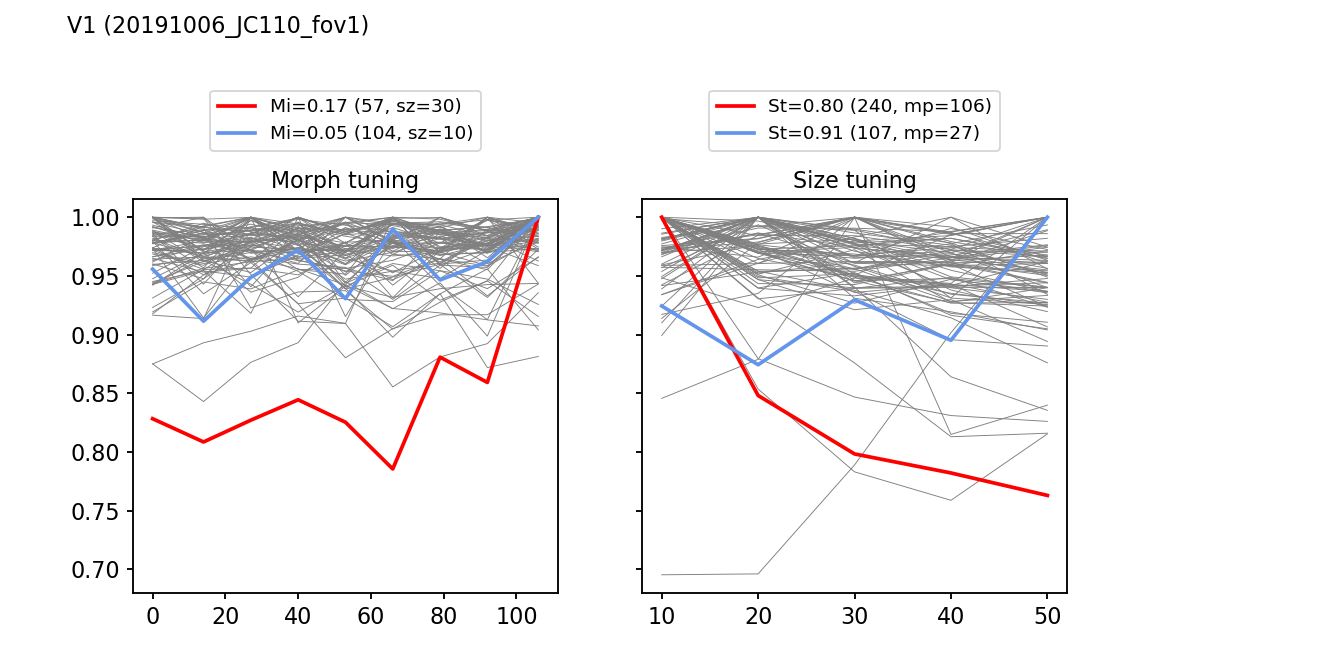

In [877]:
roi_labels = ['high', 'low'] # 'all']
roi_colors = ['red',  'cornflowerblue'] #, 'k']

fig, axn = pl.subplots(1,2, figsize=(10,5), sharey=True)

ax=axn[0]
ax.plot(morph_mat, color='gray', alpha=1, lw=0.5)
ax.set_title("Morph tuning")
rois_plot_mp = [57, 104] #, 107] #131] #104] #sorted_morph_ixs.iloc[0:topn].index.tolist()
for col, rid in zip(roi_colors, rois_plot_mp):
    best_sz = int(morph_curves[morph_curves['cell']==rid]['size'].unique())
    ax.plot(morph_mat['response', rid], color=col, lw=2, 
                label='Mi=%.2f (%i, sz=%i)' % (morph_ixs.loc[rid]['morph_ix'], rid, best_sz))
ax.legend( bbox_to_anchor=(0.5, 1.1), loc='lower center')

ax=axn[1]
ax.plot(size_mat, color='gray', alpha=1, lw=0.5)
ax.set_title("Size tuning")
rois_plot_sz = [240, 107] #, 107] #107] #sorted_size_tols.iloc[0:topn].index.tolist()

for col, rid in zip(roi_colors, rois_plot_sz):
    best_mp = int(size_curves[size_curves['cell']==rid]['morphlevel'].unique())

    ax.plot(size_mat['response', rid], color=col, lw=2, 
                label='St=%.2f (%i, mp=%i)' % (size_tols.loc[rid]['size_tol'], rid, best_mp))
ax.legend(bbox_to_anchor=(0.5, 1.1), loc='lower center')
fig.text(0.05, 0.95, '%s (%s)' % (visual_area, datakey), fontsize=12)

pl.subplots_adjust(wspace=0.2, left=0.1, right=0.8, top=0.7)

In [845]:
int(size_curves[size_curves['cell']==rid]['morphlevel'].unique())


27.0

In [647]:
rdf['response'].max()

0.7902469373691154

(0.5027450171082631, 0.6952031131698545)


IndexError: too many indices for array

In [609]:
rd['response'].reshape(9,5), 

array([[0.56981777, 0.57364562, 0.57375215, 0.55965782, 0.56425996],
       [0.57422147, 0.57669009, 0.57923581, 0.56084349, 0.57725106],
       [0.57410796, 0.58175806, 0.5784192 , 0.57808927, 0.5642958 ],
       [0.57542556, 0.57528589, 0.5706843 , 0.57750307, 0.57349688],
       [0.57701489, 0.58601119, 0.5711773 , 0.57715875, 0.56912394],
       [0.57754534, 0.56815715, 0.57131692, 0.58317837, 0.5616384 ],
       [0.57111548, 0.57836632, 0.58707754, 0.57886591, 0.57886694],
       [0.57311267, 0.57492115, 0.57766264, 0.5637506 , 0.56955009],
       [0.56571723, 0.57896397, 0.57751257, 0.57485   , 0.56766112]])

<IPython.core.display.Javascript object>


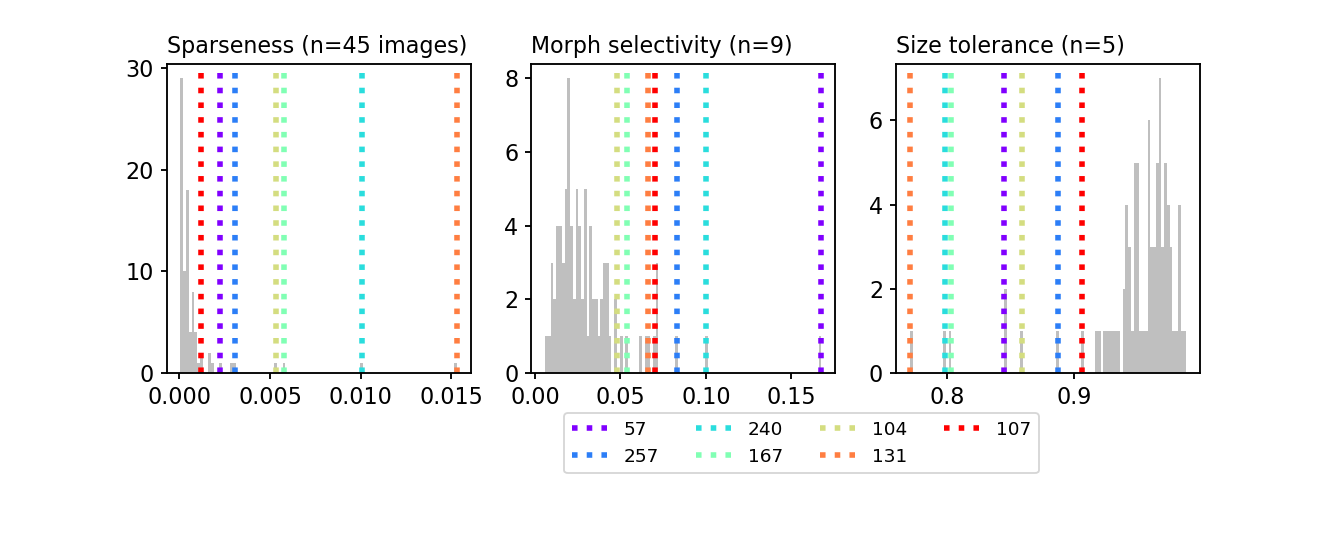

In [889]:


n_images = len(rdf['config'].unique())
n_morphs = len(np.unique([sdf['morphlevel'][c] for c in rdf['config'].unique()]))
n_sizes = len(np.unique([sdf['size'][c] for c in rdf['config'].unique()]))


rois_plot = [57, 257, 240, 167, 104, 131, 107]
color=pl.cm.rainbow(np.linspace(0, 1, len(rois_plot)))

fig, axn = pl.subplots(1,3, figsize=(10,4))

#### Sparsensess
ax=axn[0]
ax.hist(ixs_['sparseness'].values, bins=100, color='gray', alpha=0.5)
for r, c in zip(rois_plot, color):
    ax.axvline(ixs_['sparseness'].loc[r], color=c, label=r, linestyle=':', lw=3)
ax.set_title('Sparseness (n=%i images)' % n_images, loc='left')

#### Morph selectivity
ax=axn[1]
ax.hist(ixs_['morph_ix'].values, bins=100, color='gray', alpha=0.5)
for r, c in zip(rois_plot, color):
    ax.axvline(ixs_['morph_ix'].loc[r], color=c, label=r, linestyle=':', lw=3)
ax.set_title('Morph selectivity (n=%i)' % n_morphs, loc='left')

#### Size tuning
ax=axn[2]
ax.hist(ixs_['size_tol'].values, bins=100, color='gray', alpha=0.5)
for r, c in zip(rois_plot, color):
    ax.axvline(ixs_['size_tol'].loc[r], color=c, label=r, linestyle=':', lw=3)
ax.set_title('Size tolerance (n=%i)' % n_sizes, loc='left')

ax.legend(bbox_to_anchor=(0.5, -0.1), ncol=4)
pl.subplots_adjust(bottom=0.3)



In [883]:
ixs_['size_tol']

cell
4      0.982325
5      0.963247
6      0.947806
11     0.942069
12     0.973949
24     0.959558
33     0.977246
38     0.971439
46     0.968502
55     0.968547
57     0.844817
61     0.951170
65     0.943397
76     0.948799
77     0.950042
79     0.957870
85     0.974221
86     0.972298
100    0.950989
101    0.977810
102    0.953107
103    0.944793
104    0.858944
106    0.932196
107    0.905845
108    0.956141
112    0.942284
116    0.949694
118    0.918031
121    0.959964
         ...   
243    0.979516
248    0.970308
252    0.982175
255    0.925457
257    0.887450
267    0.975909
275    0.948866
276    0.941952
279    0.964935
285    0.974794
298    0.971071
301    0.969143
302    0.845798
304    0.958465
305    0.982484
307    0.963955
310    0.965554
325    0.965214
336    0.968281
337    0.967287
338    0.940227
353    0.961225
354    0.959225
355    0.988202
356    0.966682
364    0.948350
375    0.973809
380    0.985668
383    0.964546
390    0.982500
Name: size_tol, Len

In [884]:
r

107

In [ ]:
filter_by='most_fits'
blob_dsets = aggr.get_blob_datasets(filter_by=filter_by, as_dict=False, response_type=response_type,
                                    responsive_test=responsive_test, responsive_thr=responsive_thr)

all_dkeys = sdata[(sdata['experiment']==experiment)]['datakey'].unique()
unique_dkeys = blob_dsets['datakey'].unique()

n_drop = len(all_dkeys) - len(unique_dkeys)
print("Dropping %i dkeys (%i of %i dkeys unique)" % (n_drop, len(unique_dkeys), len(all_dkeys)))